## Architecture Diagram

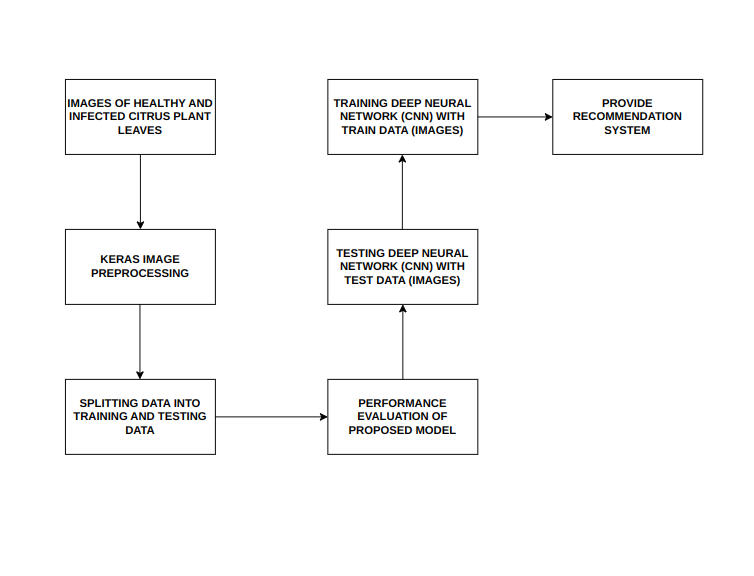

### Import Libraries

In [1]:
import os
import pandas as pd
import numpy as np
import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
import tkinter as tk
from tkinter import filedialog, WORD, INSERT, END, DISABLED
from PIL import Image
from PIL import ImageTk
from pandas import read_csv

2023-05-27 15:19:09.231507: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/sourabh/.local/lib/python3.8/site-packages/cv2/../../lib64:
2023-05-27 15:19:09.231553: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


## DATA CLEANING AND PREPROCESSING

In [2]:
dataset_path = "Leaves"
disease_names = sorted(os.listdir(dataset_path))
num_classes = len(disease_names)

### CHECKING CLASSES PRESENT IN DATASET

In [3]:
disease_names

['Black spot', 'Melanose', 'canker', 'greening', 'healthy']

## Count of Images

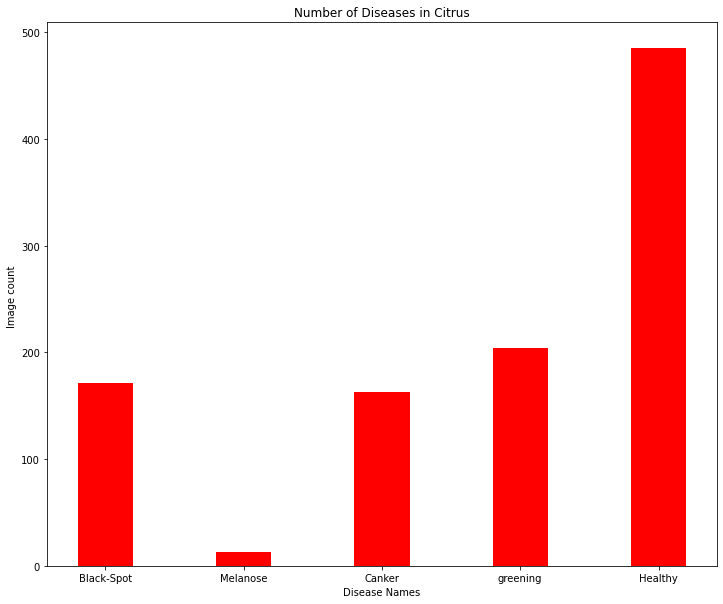

In [4]:
data = {'Black-Spot':171, 'Melanose':13, 'Canker':163,
        'greening':204,'Healthy':485}
Labels = list(data.keys())
values = list(data.values())
fig = plt.figure(figsize = (12, 10))
plt.bar(Labels, values, color ='red',
        width = 0.4)
plt.xlabel("Disease Names")
plt.ylabel("Image count ")
plt.title("Number of Diseases in Citrus")
plt.show();

### PLOTTING THE IMAGES

In [5]:
plt.figure(figsize=(15,15))
for image_batch, label_batch in dataset.take(1):
  for i in range(30):
    ax = plt.subplot(6,5,i+1)
    plt.imshow(image_batch[i].numpy().astype("uint8"))
    plt.title(dataset.class_names[label_batch[i]])
    plt.axis("ON") 

NameError: name 'dataset' is not defined

<Figure size 1080x1080 with 0 Axes>

### DEFINING DATA FOR TRAINING AND VALIDATION

In [6]:
# Create data generators for training and validation data
datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)
training_data = datagen.flow_from_directory(dataset_path, target_size=(255,255),
                                              batch_size=32, class_mode='categorical',
                                              subset='training')
validation_data = datagen.flow_from_directory(dataset_path, target_size=(255,255),
                                                   batch_size=32, class_mode='categorical',
                                                   subset='validation')

Found 831 images belonging to 5 classes.
Found 205 images belonging to 5 classes.


In [7]:
print("Batches of training data:- ",len(training_data))

Batches of training data:-  26


In [8]:
print("Batches of validation data :- ",len(validation_data))

Batches of validation data :-  7


### MODEL BUILDING

In [9]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(255, 255),
  layers.experimental.preprocessing.Rescaling(1./255),
])

2023-05-27 15:19:36.362597: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/sourabh/.local/lib/python3.8/site-packages/cv2/../../lib64:
2023-05-27 15:19:36.362617: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2023-05-27 15:19:36.362631: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (sourabh): /proc/driver/nvidia/version does not exist
2023-05-27 15:19:36.363043: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [10]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

In [11]:
model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=(32, 255, 255, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(5, activation='softmax'),
])


In [12]:
model.build(input_shape=(32, 255, 255, 3))

In [13]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 255, 255, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 253, 253, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (32, 126, 126, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (32, 124, 124, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 62, 62, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (32, 60, 60, 64)         

In [14]:
model.compile(
    optimizer='adam',
    loss="categorical_crossentropy",
    metrics=['accuracy']
)

In [15]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',patience=10,
    mode="max"
)

In [17]:
hist = model.fit(
    training_data,
    batch_size=32,
    validation_data=validation_data,callbacks=early_stopping,
    epochs=2,verbose=1
)

Epoch 1/2
26/26 [==============================] - 32s 1s/step - loss: 1.3357 - accuracy: 0.4669 - val_loss: 1.3099 - val_accuracy: 0.4732
Epoch 2/2
26/26 [==============================] - 33s 1s/step - loss: 1.3322 - accuracy: 0.4669 - val_loss: 1.3146 - val_accuracy: 0.4732


## MODEL EVALUATION

In [18]:
# Evaluate the model on the validation dataset
val_loss, val_acc = model.evaluate(validation_data)
print("Validation loss:", val_loss)
print("Validation accuracy:", val_acc)

7/7 [==============================] - 2s 267ms/step - loss: 1.3146 - accuracy: 0.4732
Validation loss: 1.3146076202392578
Validation accuracy: 0.4731707274913788


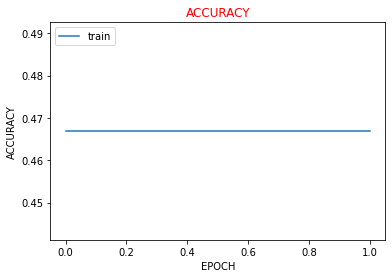

In [19]:
# accuracy of the model
import matplotlib.pyplot as plt
plt.plot(hist.history['accuracy'])
plt.title("ACCURACY",color="red")
plt.ylabel("ACCURACY")
plt.xlabel("EPOCH")
plt.legend(['train'],loc='upper left')
plt.show()   

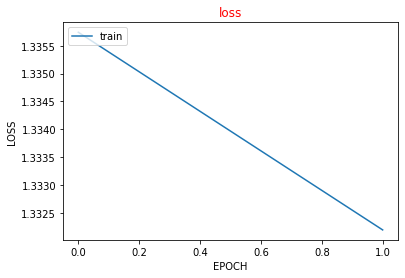

In [20]:
# loss of the model
plt.plot(hist.history['loss'])
plt.title("loss",color="red")
plt.ylabel("LOSS")
plt.xlabel("EPOCH")
plt.legend(['train'],loc='upper left')
plt.show()   

In [24]:
import os
import numpy as np
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt
from PIL import Image

# Define the dataset folder path
dataset_folder = "/home/sourabh/Desktop/BE_Project/Leaves/"

# Create a list to store image paths and their corresponding labels
image_paths = []
labels = []

# Iterate through the subfolders and collect image paths with their labels
for root, dirs, files in os.walk(dataset_folder):
    for file in files:
        if file.endswith(".jpg") or file.endswith(".png"):
            image_paths.append(os.path.join(root, file))
            labels.append(os.path.basename(root))

# Convert labels to numerical values
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(image_paths, encoded_labels, test_size=0.2, random_state=42)

# Load images and resize them to a consistent size (e.g., 64x64)
image_size = (64, 64)
X_train_images = [np.array(Image.open(image_path).resize(image_size)) for image_path in X_train]
X_test_images = [np.array(Image.open(image_path).resize(image_size)) for image_path in X_test]

# Flatten the image arrays into 1D vectors
X_train_flat = np.array([image.flatten() for image in X_train_images])
X_test_flat = np.array([image.flatten() for image in X_test_images])

# Train your classification model (e.g., using scikit-learn's RandomForestClassifier)

# Predict labels for the test set
y_pred = model.predict(X_test_flat)

# Generate the confusion matrix
confusion = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
class_names = label_encoder.classes_
disp = plot_confusion_matrix(model, X_test_flat, y_test, display_labels=class_names, cmap=plt.cm.Blues)
disp.ax_.set_title("Confusion Matrix")

plt.show()


FileNotFoundError: [Errno 2] No such file or directory: 'Leaves/valid'

In [22]:

true_labels = validation_data.classes
num_samples = len(true_labels)
predictions = model.predict(validation_data)
predicted_labels = np.argmax(predictions, axis=1)

# Calculate and display the confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)
print("Confusion Matrix:")
cm

7/7 [==============================] - 2s 216ms/step
Confusion Matrix:


array([[ 0,  0,  0,  0, 34],
       [ 0,  0,  0,  0,  2],
       [ 0,  0,  0,  0, 32],
       [ 0,  0,  0,  0, 40],
       [ 0,  0,  0,  0, 97]])

In [44]:
class_report = classification_report(true_labels, predicted_labels, target_names=disease_names)
print("Classification Report:")
print(class_report)

Classification Report:
              precision    recall  f1-score   support

  Black spot       0.00      0.00      0.00       171
    Melanose       0.00      0.00      0.00        13
      canker       0.00      0.00      0.00       163
    greening       0.00      0.00      0.00       204
     healthy       0.47      1.00      0.64       485

    accuracy                           0.47      1036
   macro avg       0.09      0.20      0.13      1036
weighted avg       0.22      0.47      0.30      1036



/home/sourabh/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/sourabh/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/sourabh/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [45]:
# Prediction of first 10 labels in testing data
y_pre=model.predict(testing_data)
y_class=[np.argmax(i) for i in y_pre]
# print("Predicted Classes :-",y_class[:10])
ls=[]
for i in y_class[:10]:
    if i==0:
        ls.append("Back Spot")
    elif i==1:
        ls.append("Canker")
    elif i==2:
        ls.append("Greening")
    elif i==3:
        ls.append("Healthy")
    else:
        ls.append("Mealnose")
print("Predicted Classes :-\n",ls)

1036/1036 [==============================] - 11s 10ms/step
Predicted Classes :-
 ['Mealnose', 'Mealnose', 'Mealnose', 'Mealnose', 'Mealnose', 'Mealnose', 'Mealnose', 'Mealnose', 'Mealnose', 'Mealnose']


In [24]:
model.save('my_model.h5')

## VGG16 MODEL

In [46]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
# Define some hyperparameters
batch_size = 32
img_height = 255
img_width = 255
num_epochs = 1

In [48]:
# Define a CNN model using the VGG16 architecture
model = tf.keras.applications.VGG16(
    include_top=True,
    weights=None,
    input_shape=(255,255, 3),
    classes=5
)

2023-05-25 11:42:06.060176: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 411041792 exceeds 10% of free system memory.
2023-05-25 11:42:06.191166: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 411041792 exceeds 10% of free system memory.
2023-05-25 11:42:06.302168: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 411041792 exceeds 10% of free system memory.


In [49]:
# Compile the model with categorical crossentropy loss and Adam optimizer
model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

In [50]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',patience=10,
    mode="max"
)

In [52]:
# Train the model on the training dataset
history = model.fit(
    training_data,
    epochs=1,
    validation_data=validation_data,callbacks=early_stopping
)

2023-05-25 11:42:34.043758: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 411041792 exceeds 10% of free system memory.
2023-05-25 11:42:34.094192: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 411041792 exceeds 10% of free system memory.


 1/26 [>.............................] - ETA: 8:00 - loss: 1.6098 - accuracy: 0.2188

KeyboardInterrupt: 

In [ ]:

# Evaluate the model on the validation dataset
val_loss, val_acc = model.evaluate(validation_data)
print("Validation loss:", val_loss)
print("Validation accuracy:", val_acc)

# Generate predictions for the validation dataset and compute the confusion matrix
y_true = validation_data.classes
y_pred = model.predict(validation_data).argmax(axis=-1)
conf_matrix = tf.math.confusion_matrix(y_true, y_pred)
print("Confusion matrix:\n", conf_matrix)



## TESTING

In [ ]:
form = tk.Tk()
form.geometry("1000x500")
form.title('Fake Review Detection Using Machine Learning')
form.resizable(False, False)
my_font1 = ('times', 18, 'bold',)
my_font2 = ('times', 15, 'bold')
l1 = tk.Label(form, text='Fake Review Detection Using Machine Learning', 
              width=70, font=my_font1, bg='white', fg='green', padx = 10, pady = 5)
l1.grid(row=1, column=1)
b1 = tk.Button(form, text='Upload Leaf Image',
               width=20, command=lambda: upload_file())
b1.grid(row=3, column=1)
l2 = tk.Label(form)
l2.grid(row=5, column=1)
l3 = tk.Label(form)
l3.grid(row=11, column=1)

def upload_file():
    global img
    f_types = [('Image Files', '*.txt;*.jpg')]
    filename = filedialog.askopenfilename(filetypes=f_types)
    img = Image.open(filename)
    img.save("leaf.png")
    img_resized = img.resize((255, 255))
    img = ImageTk.PhotoImage(img_resized)
    l2.config(image=img)
    l2.image = img
    b3 = tk.Button(form, text='Predict',
                   width=20, command=lambda: prediction())
    b3.grid(row=9, column=1)

def prediction():
    model =  models.load_model("my_model.h5")
    class_names = ['Black spot', 'Melanose', 'canker', 'greening', 'healthy']
    img = cv2.imread("leaf.png")
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (255, 255))
    img = (np.expand_dims(img,0))
    weights = model.predict(img)
    img_prediction = weights.argmax(axis=1)[0]
    prediction = class_names[img_prediction]
    l3.config(text=f"Prediction: {prediction}", font=my_font2, fg="green")    
    l4 = tk.Text(form, wrap=WORD, width=90, height=5, fg="green")
    l4.delete('1.0', END)    
    if prediction != "healthy":
            treatments = read_csv("treatments.csv")       
            treatment = (treatments.loc[treatments['disease'] == prediction]).values.tolist() 
            l3.config(fg="red")    
            l4.insert(INSERT, f"Recommendation(Treatment) : {treatment[0][1]}") 
            l4.config(fg="red")
    elif prediction != "healthy":
          l4.insert(INSERT, f"\t\t No Disease is detected")       
    l4.config(state=DISABLED, highlightthickness = 0, borderwidth=0, bg='#f0f0f0')
    l4.grid(row=20, column=1)
           
form.mainloop()

2023-05-26 01:44:34.586738: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/sourabh/.local/lib/python3.8/site-packages/cv2/../../lib64:
2023-05-26 01:44:34.586761: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2023-05-26 01:44:34.586777: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (sourabh): /proc/driver/nvidia/version does not exist
2023-05-26 01:44:34.587055: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


1/1 [==============================] - 0s 147ms/step
